In [92]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from typing import List
#import h5py

### Data loading for new acquisition and preprocessing

In [7]:
def add_open_loop_column(df,shift=0):
    # Calculate the number of seconds within the current minute
    seconds_in_minute = (df['time']+shift) % 60
    
    # Create the 'is_open_loop' column
    df['is_open_loop'] = np.where((seconds_in_minute >= 50) & (seconds_in_minute < 60), 1, 0)
    
    return df

#behav_df = add_open_loop_column(behav_df,-34.5)
#behav_df

In [94]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/"
example_path_data = base_path+"20241105-1_MBON09_blocks/data/"
example_path_results = base_path+"20241105-1_MBON09_blocks/results/"
trial_num = 1
is_mat73, roi_df, dff_raw = imaging_behavior_functions.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
behav_df, neural_df_new = imaging_behavior_functions.load_matfile_to_df(example_path_data, trial_num)
behav_df = imaging_behavior_functions.rename_dataframe(behav_df)
behav_df = imaging_behavior_functions.detect_jumps_unwrapped(behav_df, 'heading', 'time', jump_threshold=np.pi/4, min_time_between_jumps=30)
behav_df = imaging_behavior_functions.make_df_behavior_new(behav_df)
behav_df, block_boundaries = imaging_behavior_functions.label_blocks(behav_df,50)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
#behav_df = imaging_behavior_functions.label_block(behav_df, 150)


In [99]:
behav_df

,xPos,yPos,fwV,sideV,yawV,heading,heading_diff,time,odor,odor_state,jump_detected,abssideV,absyawV,net_motion,net_motion_state,heading_adj,block
0,0.000000,0.000000,8.705311,0.220605,0.700995,4.093211,-0.560796,0.000000,3.132827,True,0,0.220605,0.700995,9.626910,1,4.093211,0
1,-0.059898,0.690258,6.262746,-0.331119,-0.479776,4.009596,0.383821,0.107155,-3.137312,False,0,0.331119,0.479776,7.073642,1,4.009596,0
2,-0.048560,1.129152,4.102044,-0.884064,-1.679971,4.131152,1.343977,0.218111,-3.140503,False,0,0.884064,1.679971,6.666079,1,4.131152,0
3,0.068802,1.475239,3.358867,-0.401495,-2.322813,4.426836,1.858250,0.326430,-3.138880,False,0,0.401495,2.322813,6.083174,1,4.426836,0
4,0.396821,2.008385,5.734349,0.327980,-2.106177,4.641603,1.684942,0.435954,-3.139859,False,0,0.327980,2.106177,8.168507,1,4.641603,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9349,865.885681,-953.052368,12.753605,0.065374,-0.967625,4.232531,0.774100,1019.555298,-3.139714,False,0,0.065374,0.967625,13.786604,1,136.179428,2
9350,866.153687,-951.754517,12.074477,0.515323,-1.013846,4.294440,0.811077,1019.664124,-3.139371,False,0,0.515323,1.013846,13.603646,1,136.241333,2
9351,866.537048,-950.534912,11.747313,0.954793,-1.010969,4.393241,0.808775,1019.773621,-3.139746,False,0,0.954793,1.010969,13.713075,1,136.340134,2
9352,867.075928,-949.285034,12.170052,1.724940,-1.086228,4.492474,0.868983,1019.881958,-3.139555,False,0,1.724940,1.086228,14.981220,1,136.439377,2


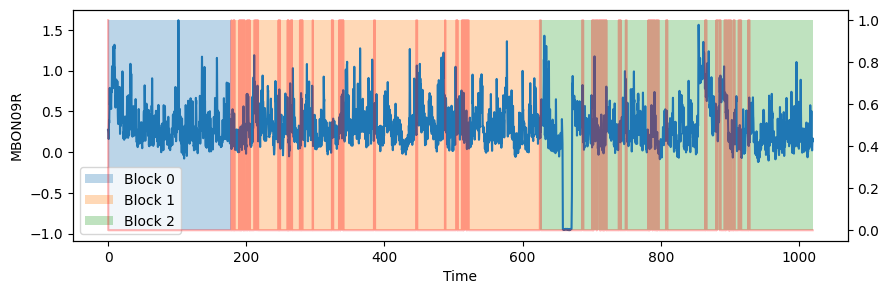

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(neural_df.time, neural_df.MBON09R)
ax2 = ax.twinx()
ax2.plot(behav_df.time, behav_df.odor_state, color='red',alpha=0.3)
# Assuming behav_df.block contains discrete values for different blocks
# that correspond to different chunks of time on the time axis
# Shade regions based on block labels in behav_df
for block_value in behav_df.block.unique():
    # Get the time indices for this block
    block_times = behav_df.time[behav_df.block == block_value]
    
    # Shade the region corresponding to the current block
    ax.fill_betweenx([neural_df.MBON09R.min(), neural_df.MBON09R.max()],
                     block_times.min(), block_times.max(),
                     alpha=0.3, label=f'Block {block_value}')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('MBON09R')
ax.legend()

plt.show()

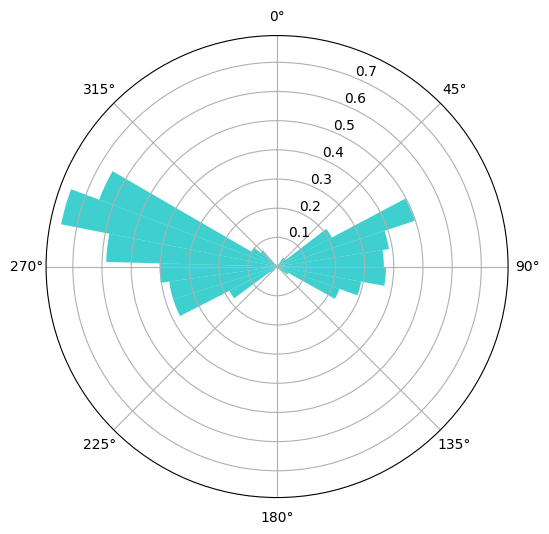

In [98]:
def plot_circular_histogram(df):
    """
    Plots a circular (rose) histogram of heading values for a specific odor.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing 'heading' and 'odor' columns.
    odor_value (str or int): The specific odor for which the circular histogram is plotted.
    """
    # Filter the DataFrame by the specified odor
    odor_df = df[df['odor'] > -1.5]
    
    # Convert the 'heading' to radians
    heading_radians = odor_df['heading']

    # Create the polar plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='polar')
    
    # Plot a histogram on the polar axis
    bins = 30  # Number of bins for the histogram
    ax.hist(heading_radians, bins=bins, density=True, color='c', alpha=0.75)

    # Customize the plot
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_theta_zero_location('N')  # Zero at the top (north)
    
    # Set title with the odor value
    
    plt.show()

plot_circular_histogram(behav_df)


### Old loading

In [27]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/MBON09/"
example_path_data = base_path+"20230728-4_MBON09_GCAMP7f_patchy_strip_fly2/data/"
example_path_results = base_path+"20230728-4_MBON09_GCAMP7f_patchy_strip_fly2/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

#### Explore circulr clustering and segment splitting 

Number of peaks detected: 3


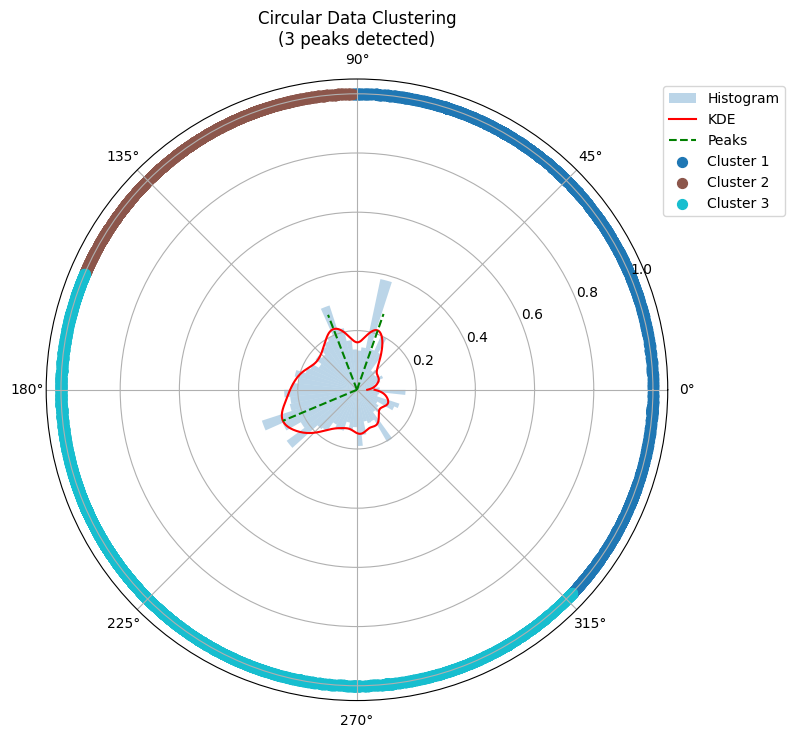

In [68]:
def circular_kde(theta, bandwidth=0.1):
    """
    Perform Kernel Density Estimation (KDE) on circular data.
    """
    theta_grid = np.linspace(0, 2 * np.pi, 500)
    kde = gaussian_kde(theta, bw_method=bandwidth)
    kde_values = kde(theta_grid)
    
    return kde_values, theta_grid

def find_density_peaks(kde_values, theta_grid, threshold=0.5):
    """
    Find peaks in the KDE distribution to identify clusters.
    Returns both peak angles and number of peaks found.
    """
    peaks = np.where((kde_values[1:-1] > kde_values[:-2]) & 
                    (kde_values[1:-1] > kde_values[2:]))[0] + 1
    peak_angles = theta_grid[peaks][kde_values[peaks] > threshold]
    num_peaks = len(peak_angles)
    return peak_angles, num_peaks

def assign_clusters(theta, peak_angles):
    """
    Assign data points to clusters based on proximity to density peaks.
    """
    distances = [np.abs(np.angle(np.exp(1j * (theta - peak)))) for peak in peak_angles]
    cluster_labels = np.argmin(distances, axis=0)
    cluster_peak_angles = peak_angles[cluster_labels]
    return cluster_labels, cluster_peak_angles

def get_dynamic_colors(n_colors):
    """
    Generate a list of distinct colors based on the number of clusters.
    
    Parameters:
    - n_colors: Number of distinct colors needed
    
    Returns:
    - List of RGB colors
    """
    if n_colors <= 10:
        # Use tab10 for up to 10 colors
        return plt.cm.tab10(np.linspace(0, 1, n_colors))
    else:
        # For more than 10 colors, use hsv colormap
        return plt.cm.hsv(np.linspace(0, 1, n_colors))

def plot_circular_clusters(behav_df, kde_values, theta_grid, peak_angles, cluster_labels):
    """
    Plot the clustering results with dynamically assigned colors.
    """
    # Count unique clusters
    n_clusters = len(np.unique(cluster_labels))
    
    # Get dynamic color palette
    colors = get_dynamic_colors(n_clusters)
    
    # Create the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
    
    # Plot histogram and KDE
    ax.hist(behav_df['heading'], bins=60, density=True, alpha=0.3, label="Histogram")
    ax.plot(theta_grid, kde_values, label="KDE", color="red")
    
    # Mark the peaks
    peak_line = None
    for peak in peak_angles:
        line = ax.plot([peak, peak], [0, max(kde_values)], 
                      color='green', linestyle="--")
        if peak_line is None:
            peak_line = line[0]
    
    # Add peak line to legend only once
    if peak_line is not None:
        peak_line.set_label("Peaks")
    
    # Plot clusters with dynamic colors
    for cluster in range(n_clusters):
        cluster_data = behav_df[behav_df['cluster_label'] == cluster]['heading']
        ax.scatter(cluster_data, np.ones_like(cluster_data), 
                  label=f'Cluster {cluster+1}', 
                  s=50, 
                  color=colors[cluster])
    
    ax.set_title(f"Circular Data Clustering\n({n_clusters} peaks detected)")
    ax.legend(bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    return fig, ax

# Example usage:
def analyze_circular_clusters(behav_df, bandwidth=0.1, threshold=0.5):
    """
    Complete analysis pipeline for circular clustering.
    
    Returns:
    - Modified DataFrame
    - Number of peaks found
    - Figure handle
    """
    # Perform KDE
    kde_values, theta_grid = circular_kde(behav_df['heading'], bandwidth)
    
    # Find peaks and get count
    peak_angles, num_peaks = find_density_peaks(kde_values, theta_grid, threshold)
    
    # Assign clusters
    cluster_labels, cluster_peak_angles = assign_clusters(
        behav_df['heading'].values, 
        peak_angles
    )
    
    # Add results to DataFrame
    behav_df = behav_df.copy()
    behav_df['cluster_label'] = cluster_labels
    behav_df['cluster_peak_angle'] = cluster_peak_angles
    
    # Create visualization
    fig, ax = plot_circular_clusters(
        behav_df, 
        kde_values, 
        theta_grid, 
        peak_angles, 
        cluster_labels
    )
    
    return behav_df, num_peaks, fig

# Usage example:
behav_df, n_peaks, fig = analyze_circular_clusters(behav_df, threshold=0.2)
print(f"Number of peaks detected: {n_peaks}")
plt.show()


#### side section for finding trajectory split

In [27]:
def find_best_splits(df: pd.DataFrame, num_clusters: int) -> tuple[int, int]:
    """
    Find the best split points that divide the trajectory into `num_clusters` segments
    with the most dominant cluster in each segment.
    
    Args:
    df (pd.DataFrame): DataFrame containing the trajectory data
    num_clusters (int): Number of clusters (should be 3 for this implementation)
    
    Returns:
    tuple[int, int]: Best split indices
    """
    if num_clusters != 3:
        raise ValueError("This implementation only supports 3 clusters")

    best_split_idx_1, best_split_idx_2 = 0, 0
    best_split_score = 0
    total_points = len(df)

    # Pre-compute cluster counts for efficiency
    cluster_counts = [np.cumsum(df['cluster_label'] == i) for i in range(num_clusters)]
    #print(cluster_counts)
    for split_idx_1 in range(1, total_points - 2):
        for split_idx_2 in range(split_idx_1 + 1, total_points - 1):
            # Calculate dominant counts for each segment
            dominant_counts = [
                max(cluster_counts[i][split_idx_1] for i in range(num_clusters)),
                max(cluster_counts[i][split_idx_2] - cluster_counts[i][split_idx_1] for i in range(num_clusters)),
                max(cluster_counts[i][len(df)-1] - cluster_counts[i][split_idx_2] for i in range(num_clusters))
            ]
            
            total_dominant_points = sum(dominant_counts)

            if total_dominant_points > best_split_score:
                best_split_score = total_dominant_points
                best_split_idx_1, best_split_idx_2 = split_idx_1, split_idx_2

    return best_split_idx_1, best_split_idx_2

In [28]:
def find_best_splits(df: pd.DataFrame, num_clusters: int, num_segments: int, step_size: int = 3, min_segment_length: int = 100) -> List[int]:
    """
    Find the best split points that divide the trajectory into `num_segments` segments
    with the most dominant cluster in each segment, using a specified step size for faster processing
    and ensuring a minimum segment length.
    
    Args:
    df (pd.DataFrame): DataFrame containing the trajectory data
    num_clusters (int): Number of clusters
    num_segments (int): Number of segments to split the data into
    step_size (int): Step size for searching split points (default: 3)
    min_segment_length (int): Minimum length of each segment (default: 10)
    
    Returns:
    List[int]: Best split indices
    """
    if num_segments < 2:
        raise ValueError("Number of segments must be at least 2")

    total_points = len(df)
    if total_points < num_segments * min_segment_length:
        raise ValueError(f"Not enough points to create {num_segments} segments with minimum length of {min_segment_length}")

    best_splits = [0] * (num_segments - 1)
    best_split_score = 0

    # Pre-compute cluster counts for efficiency
    cluster_counts = [np.cumsum(df['cluster_label'].values == i) for i in range(num_clusters)]

    def evaluate_splits(splits: List[int]) -> int:
        """Evaluate the quality of a given set of splits"""
        splits = [0] + splits + [total_points-1]
        dominant_counts = [
            max(cluster_counts[i][splits[j+1]] - cluster_counts[i][splits[j]] 
                for i in range(num_clusters))
            for j in range(num_segments)
        ]
        return sum(dominant_counts)

    def find_splits_recursive(start: int, end: int, depth: int):
        """Recursively find the best splits"""
        nonlocal best_splits, best_split_score

        if depth == num_segments - 1:
            # Check if the last segment meets the minimum length requirement
            if end - start >= min_segment_length:
                score = evaluate_splits(best_splits)
                if score > best_split_score:
                    best_split_score = score
            return

        # Calculate the maximum allowed split point for this depth
        max_split = end - (num_segments - depth - 1) * min_segment_length

        for split in range(start + min_segment_length, max_split + 1, step_size):
            best_splits[depth] = split
            find_splits_recursive(split, end, depth + 1)

    find_splits_recursive(0, total_points, 0)
    
    # Check if a valid solution was found
    if best_split_score == 0:
        raise ValueError("Could not find a valid segmentation with the given constraints")

    return best_splits

# Example usage
# df = pd.DataFrame(...)  # Your dataframe with 'heading_cluster' column
# best_splits = find_best_splits(df, num_clusters=3, num_segments=3, step_size=5, min_segment_length=20)
# print(f"Best split points: {best_splits}")



#### Plot segment based activity heading tuning (based on manual index)

Motion filtering summary:
Original points: 12472
Points kept: 9475 (76.0%)
Points removed: 2997 (24.0%)


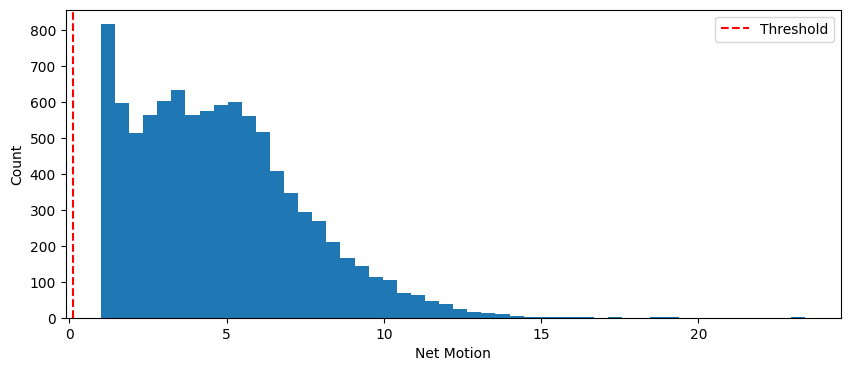

In [81]:
# behav_df filtering
def filter_by_motion(behav_df, motion_threshold=0.0, motion_col='net_motion', return_mask=False):
    """
    Filter behavioral DataFrame based on net_motion threshold.
    
    Parameters:
    -----------
    behav_df : pandas.DataFrame
        Behavioral DataFrame containing motion data
    motion_threshold : float, default=0.0
        Minimum threshold for net_motion. Rows with values below this are filtered out
    motion_col : str, default='net_motion'
        Name of the column containing motion data
    return_mask : bool, default=False
        If True, also return the boolean mask used for filtering
        
    Returns:
    --------
    pandas.DataFrame or tuple
        Filtered DataFrame, or (filtered DataFrame, mask) if return_mask=True
    
    Example:
    --------
    # Basic filtering
    filtered_df = filter_by_motion(behav_df, motion_threshold=0.1)
    
    # Get both filtered df and mask
    filtered_df, mask = filter_by_motion(behav_df, motion_threshold=0.1, return_mask=True)
    print(f"Kept {mask.sum()} out of {len(mask)} points ({mask.mean()*100:.1f}%)")
    """
    # Check if motion column exists
    if motion_col not in behav_df.columns:
        raise ValueError(f"Column '{motion_col}' not found in DataFrame")
    
    # Create motion mask
    motion_mask = behav_df[motion_col] >= motion_threshold
    
    # Apply filter
    filtered_df = behav_df[motion_mask].copy()
    
    # Print summary of filtering
    n_original = len(behav_df)
    n_kept = len(filtered_df)
    percent_kept = (n_kept / n_original) * 100
    
    print(f"Motion filtering summary:")
    print(f"Original points: {n_original}")
    print(f"Points kept: {n_kept} ({percent_kept:.1f}%)")
    print(f"Points removed: {n_original - n_kept} ({100 - percent_kept:.1f}%)")
    
    if return_mask:
        return filtered_df, motion_mask
    return filtered_df

# Example usage:

# Get both filtered data and mask
motion_threshold=1
behav_df, motion_mask = filter_by_motion(behav_df, 
                                                motion_threshold, 
                                                return_mask=True)

# Apply same mask to neural_df if needed
neural_df = neural_df[motion_mask]

# Visualize motion distribution before choosing threshold
plt.figure(figsize=(10, 4))
plt.hist(behav_df['net_motion'], bins=50)
plt.axvline(x=0.1, color='r', linestyle='--', label='Threshold')
plt.xlabel('Net Motion')
plt.ylabel('Count')
plt.legend()
plt.show()


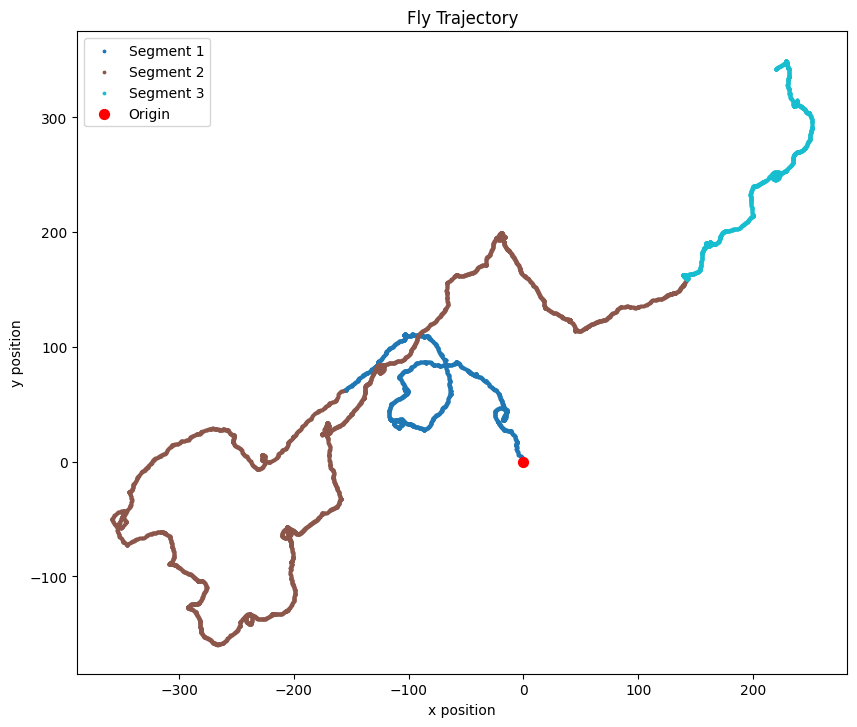

In [82]:
def plot_trajectory_segments(xPos, yPos, query_indices=None, behav_df=None, label=None):
    """
    Plot trajectory with different colors for each segment and add segment labels to dataframe.
    
    Parameters:
    -----------
    xPos : array-like
        X coordinates of the trajectory
    yPos : array-like
        Y coordinates of the trajectory
    query_indices : list
        List of indices that define the segments. If None, plots entire trajectory in one color
    behav_df : pandas DataFrame, optional
        Behavioral data frame containing additional labels
    label : str, optional
        Column name in behav_df to use for coloring (if segment-based coloring is not used)
        
    Returns:
    --------
    tuple
        (matplotlib axis, modified DataFrame with segment labels)
    """
    # If behav_df is not provided, create a new one
    if behav_df is None:
        behav_df = pd.DataFrame()
    else:
        behav_df = behav_df.copy()  # Create a copy to avoid modifying the original
    
    # Calculate aspect ratio for proper scaling
    x_range = max(xPos) - min(xPos)
    y_range = max(yPos) - min(yPos)
    aspect_ratio = y_range / x_range

    # Set figure dimensions
    fig_width = 10
    fig_height = fig_width * aspect_ratio
    plt.figure(figsize=(fig_width, fig_height))

    # If query indices are provided, plot segments and create labels
    if query_indices is not None:
        # Create a list of all segment boundaries including start and end
        boundaries = [0] + sorted(query_indices) + [len(xPos)]
        
        # Create a colormap with distinct colors for each segment
        colors = plt.cm.tab10(np.linspace(0, 1, len(boundaries)-1))
        
        # Create segment labels array
        segment_labels = np.zeros(len(xPos))
        
        # Plot each segment with a different color and assign segment labels
        for i in range(len(boundaries)-1):
            start_idx = boundaries[i]
            end_idx = boundaries[i+1]
            
            # Plot segment
            plt.scatter(xPos[start_idx:end_idx], 
                       yPos[start_idx:end_idx], 
                       c=[colors[i]], 
                       s=3,
                       label=f'Segment {i+1}')
            
            # Assign segment labels
            segment_labels[start_idx:end_idx] = i + 1
        
        # Add segment labels to dataframe
        behav_df['segment_id'] = segment_labels
    
    # If no query indices but label is provided and exists in behav_df
    elif label is not None and label in behav_df.columns:
        scatter = plt.scatter(xPos, yPos, c=behav_df[label], s=3)
        plt.colorbar(scatter, label=label)
        # In this case, assign all points to segment 1
        behav_df['segment_id'] = 1
    
    # Default case: plot entire trajectory in one color
    else:
        plt.scatter(xPos, yPos, s=3)
        # In this case, assign all points to segment 1
        behav_df['segment_id'] = 1

    # Mark the origin
    plt.scatter(0, 0, color='red', s=50, label='Origin')

    # Set equal aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    # Add labels and title
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Fly Trajectory')
    plt.legend()

    return plt.gca(), behav_df

# Example usage:
# query_indices = [5450, 8000]
# ax, modified_df = plot_trajectory_segments(xPos, yPos, query_indices=query_indices, behav_df=behav_df)
# plt.show()
# print(modified_df['segment_id'].value_counts())  # Check segment distribution

# Example usage:
query_indices = block_boundaries
ax, behav_df = plot_trajectory_segments(behav_df.xPos, behav_df.yPos, query_indices , behav_df)
plt.show()

In [83]:
def calc_circular_mode(circular_data, num_bins=30):
    """
    Calculate the mode angle of circular data using histogram binning.
    
    Parameters:
    -----------
    circular_data : array-like
        Array of angles in radians, expected to be in range [0, 2π]
    num_bins : int, optional
        Number of bins to use for the histogram (default: 30)
        
    Returns:
    --------
    float
        Mode angle in radians
    """
    # Create histogram of the circular data
    n, bins = np.histogram(circular_data, bins=num_bins, range=(0, 2*np.pi))
    
    # Find the bin with the highest frequency
    max_bin_index = np.argmax(n)
    
    # Calculate the mode as the center of the highest-frequency bin
    mode_angle = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2
    
    return mode_angle

In [84]:
def calc_segment_modes(df, heading_col='heading', segment_col='segment_id', num_bins=30):
    """
    Calculate the mode heading for each segment in the trajectory.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing heading angles and segment IDs
    heading_col : str, optional
        Name of the column containing heading angles (default: 'heading')
    segment_col : str, optional
        Name of the column containing segment IDs (default: 'segment_id')
    num_bins : int, optional
        Number of bins to use for circular histogram (default: 30)
        
    Returns:
    --------
    numpy.ndarray
        Array of mode headings for each segment, indexed by segment ID - 1
        (i.e., segment 1's mode is at index 0)
    """
    # Get unique segment IDs, sorted
    segments = sorted(df[segment_col].unique())
    
    # Initialize array to store mode headings
    mode_headings = np.zeros(len(segments))
    
    # Calculate mode heading for each segment
    for seg_id in segments:
        # Get headings for this segment
        segment_headings = df[df[segment_col] == seg_id][heading_col]
        
        # Calculate mode heading for this segment
        mode_headings[int(seg_id)-1] = calc_circular_mode(segment_headings, num_bins)
    
    return mode_headings

# Example usage:
unique_mode_headings = calc_segment_modes(behav_df, heading_col='heading', segment_col='segment_id')
# print(f"Mode headings for each segment: {np.rad2deg(mode_headings)} degrees")

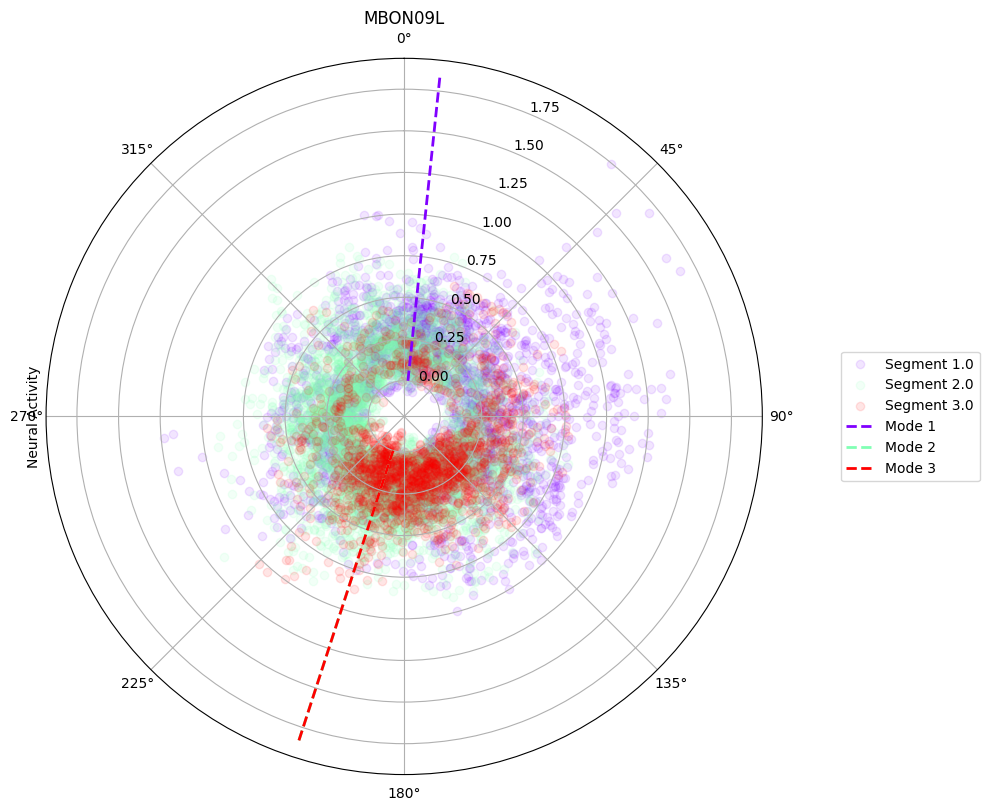

In [85]:
def plot_heading_tuning_circular(behav_df, neural_df, filtered_columns, unique_mode_headings, segment_column='segment_id'):
    """
    Plot heading tuning for different segments of a time series for multiple neurons.
    
    Parameters:
    -----------
    behav_df : DataFrame
        DataFrame containing behavioral data including 'heading' and segment column
    neural_df : DataFrame
        DataFrame containing neural data
    filtered_columns : list
        List of neuron column names to plot
    unique_mode_headings : array-like, optional
        List of mode headings to plot as radial lines
    segment_column : str, default='segment_id'
        Column name in behav_df to use for segmenting the data
    
    Returns:
    --------
    tuple
        (fig, axes) Matplotlib figure and axes objects
    """
    # Get unique segments automatically from the DataFrame
    unique_seg = np.sort(behav_df[segment_column].unique())
    
    n_neurons = len(filtered_columns)
    fig, axes = plt.subplots(1, n_neurons, 
                            figsize=(10*n_neurons, 10), 
                            subplot_kw={'projection': 'polar'})
    
    # Convert axes to array if single subplot
    if n_neurons == 1:
        axes = [axes]
    
    # Define colors for segments
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_seg)))

    # Plot each neuron
    for ax_idx, (ax, neuron) in enumerate(zip(axes, filtered_columns)):
        # Plot segments
        for i, seg in enumerate(unique_seg):
            mask = behav_df[segment_column] == seg
            ax.scatter(behav_df.loc[mask, 'heading'], 
                      neural_df.loc[mask, neuron], 
                      color=colors[i], 
                      alpha=0.1, 
                      label=f'Segment {seg}')
        
        # Set polar plot properties
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title(neuron)
        
        # Add ylabel only to first subplot
        if ax_idx == 0:
            ax.set_ylabel("Neural Activity")
        
        # Plot mode headings
        y_max = ax.get_ylim()[1]
        for i, mode_hd in enumerate(unique_mode_headings):
            ax.plot([mode_hd, mode_hd], 
                   [0, y_max], 
                   color=colors[i % len(colors)], 
                   linewidth=2, 
                   linestyle='--', 
                   label=f'Mode {i+1}')
        
        # Add legend to last subplot
        if ax_idx == n_neurons - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout()
    return fig, axes

# Example usage:


# With pre-calculated mode headings
fig, axes = plot_heading_tuning_circular(
    behav_df,
    neural_df,
    filtered_columns=['MBON09L'],
    unique_mode_headings=unique_mode_headings
)
plt.show()


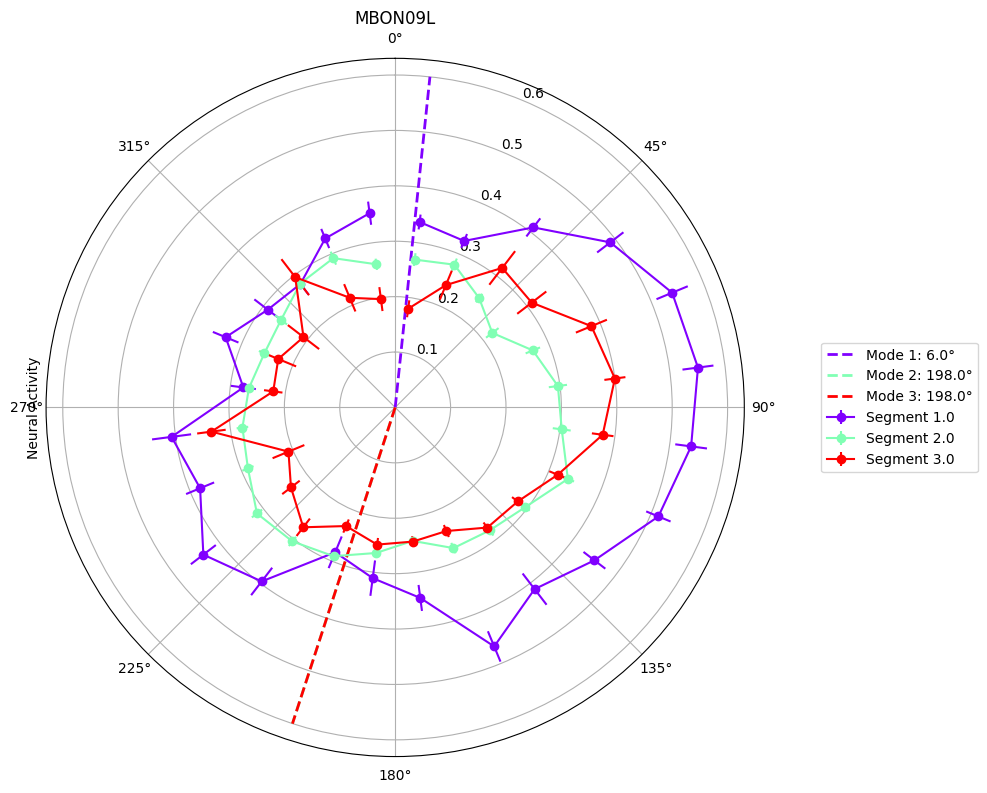

In [86]:

def binned_stats(headings, values, bins):
    """
    Calculate binned averages and standard errors.
    
    Parameters:
    - headings: array of angular data (in radians).
    - values: corresponding values (e.g., MBON09L) to be averaged.
    - bins: number of bins or a list of bin edges for angular data.
    
    Returns:
    - bin_centers: array of bin centers (in radians).
    - bin_means: array of mean values for each bin.
    - bin_errors: array of standard errors for each bin.
    """
    binned, bin_edges = pd.cut(headings, bins=bins, labels=False, retbins=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    bin_means = []
    bin_errors = []
    for i in range(len(bin_edges) - 1):
        bin_values = values[binned == i]
        bin_means.append(np.mean(bin_values))
        bin_errors.append(np.std(bin_values) / np.sqrt(len(bin_values)))

    return bin_centers, np.array(bin_means), np.array(bin_errors)
def plot_binned_heading_tuning(behav_df, neural_df, filtered_columns, unique_mode_headings=None, 
                             n_bins=16, segment_column='segment_id'):
    """
    Plot binned heading tuning for different segments of a time series for multiple neurons.
    
    Parameters:
    -----------
    behav_df : DataFrame
        DataFrame containing behavioral data including 'heading' and segment column
    neural_df : DataFrame
        DataFrame containing neural data
    filtered_columns : list
        List of neuron column names to plot
    unique_mode_headings : array-like, optional
        List of mode headings to plot as radial lines
    n_bins : int, default=16
        Number of bins for circular data
    segment_column : str, default='segment_id'
        Column name in behav_df to use for segmenting the data
    
    Returns:
    --------
    tuple
        (fig, axes) Matplotlib figure and axes objects
    """
    # Get unique segments automatically
    unique_seg = np.sort(behav_df[segment_column].unique())
    
    n_neurons = len(filtered_columns)
    fig, axes = plt.subplots(1, n_neurons, 
                            figsize=(10*n_neurons, 10), 
                            subplot_kw={'projection': 'polar'})
    
    # Convert axes to array if single subplot
    if n_neurons == 1:
        axes = [axes]
    
    # Setup colors and bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_seg)))
    bins = np.linspace(0, 2 * np.pi, n_bins + 1)
    

    # Plot each neuron
    for ax_idx, (ax, neuron) in enumerate(zip(axes, filtered_columns)):
        # Plot binned data for each segment
        for i, seg in enumerate(unique_seg):
            mask = behav_df[segment_column] == seg
            headings = behav_df.loc[mask, 'heading']
            values = neural_df.loc[mask, neuron]
            
            centers, means, errors = binned_stats(headings, values, bins)
            
            ax.errorbar(centers, means, 
                       yerr=errors, 
                       fmt='o-', 
                       label=f'Segment {seg}', 
                       color=colors[i])
        
        # Set polar plot properties
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title(neuron)
        
        # Add ylabel only to first subplot
        if ax_idx == 0:
            ax.set_ylabel("Neural Activity")
        
        # Plot mode headings if provided
        if unique_mode_headings is not None:
            y_max = ax.get_ylim()[1]
            for i, mode_hd in enumerate(unique_mode_headings):
                ax.plot([mode_hd, mode_hd], 
                       [0, y_max], 
                       color=colors[i], 
                       linewidth=2, 
                       linestyle='--', 
                       label=f'Mode {i+1}: {np.rad2deg(mode_hd):.1f}°')
        
        # Add legend to last subplot
        if ax_idx == n_neurons - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout()
    return fig, axes

# Example usage:
# With custom settings
fig, axes = plot_binned_heading_tuning(
    behav_df,
    neural_df,
    filtered_columns=['MBON09L'],
    n_bins=24,  # more bins
    unique_mode_headings=unique_mode_headings
)
plt.show()


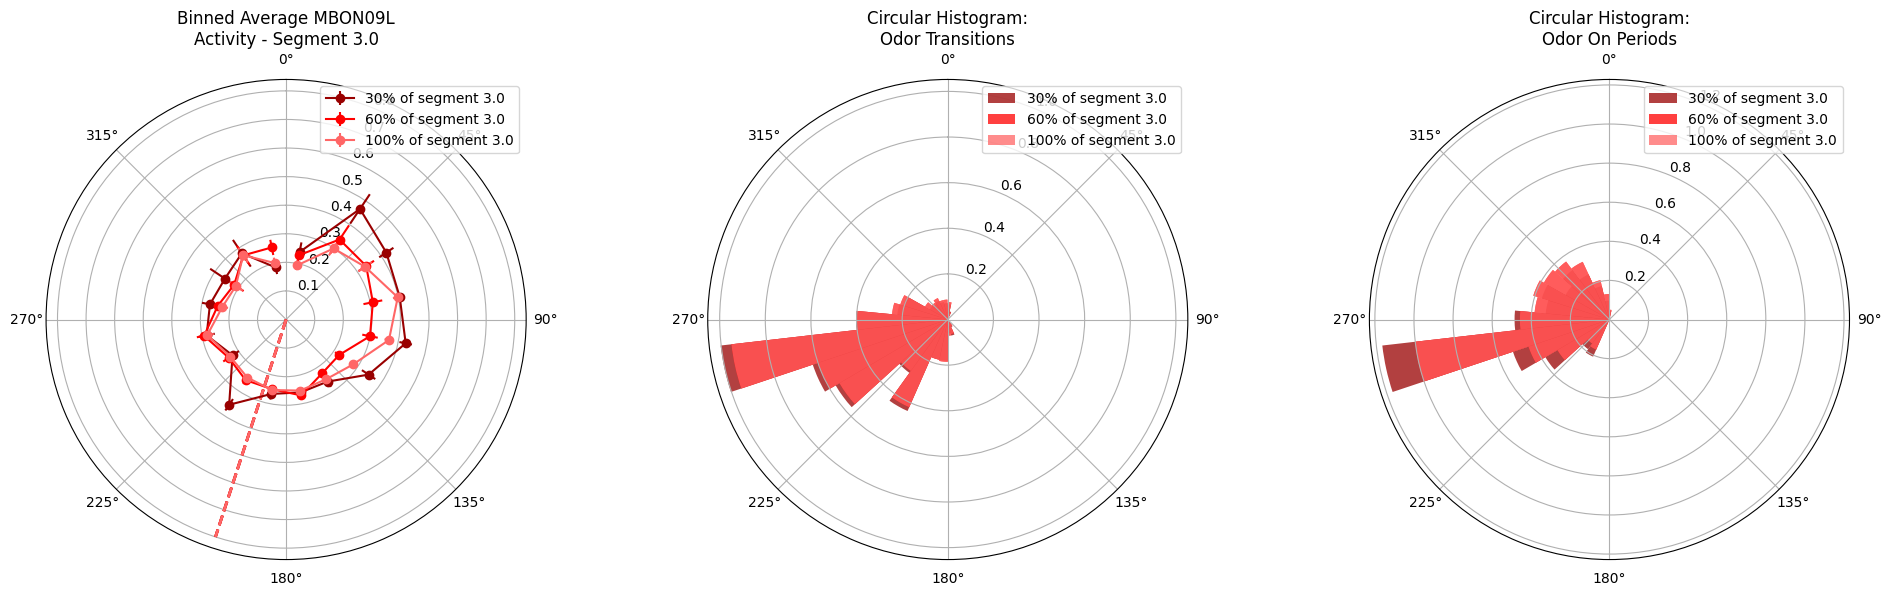

In [91]:
def generate_color_shades_from_rgb(rgb_color, n_shades=3):
    """
    Generate different shades of a color from RGB array.
    
    Parameters:
    -----------
    rgb_color : array-like
        RGB color values in range [0, 1] or [0, 255]
    n_shades : int
        Number of shades to generate
        
    Returns:
    --------
    list
        List of RGB arrays from lightest to darkest
    """
    from colorsys import rgb_to_hls, hls_to_rgb
    import numpy as np
    
    # Convert RGB to range [0, 1] if necessary
    rgb = np.array(rgb_color)
    if rgb.max() > 1:
        rgb = rgb / 255.0
        
    # Convert to HLS
    h, l, s = rgb_to_hls(rgb[0], rgb[1], rgb[2])
    
    # Generate shades by varying lightness
    shades = []
    for i in range(n_shades):
        # Calculate new lightness
        # This will spread the lightness values between 0.3 and 0.7
        new_l = 0.3 + (0.4 * i / (n_shades - 1))
        
        # Convert back to RGB
        new_rgb = hls_to_rgb(h, new_l, s)
        
        # Convert to numpy array
        shade = np.array(new_rgb)
        shades.append(shade)
    
    return shades

# Example usage and visualization:
def preview_rgb_shades(shades, title='RGB Color Shades'):
    """
    Visualize RGB color shades.
    
    Parameters:
    -----------
    shades : list
        List of RGB arrays
    title : str
        Plot title
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(8, 2))
    for i, color in enumerate(shades):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color))
    ax.set_xlim(-0.1, len(shades) + 0.1)
    ax.set_ylim(-0.1, 1.1)
    ax.axis('off')
    plt.title(title)
    plt.show()

# Example usage:
"""
# For RGB in range [0, 1]
rgb_color = np.array([1.0, 0.0, 0.0])  # Red
shades = generate_color_shades_from_rgb(rgb_color, 3)
preview_rgb_shades(shades, 'Shades of RGB Red')

# For RGB in range [0, 255]
rgb_color = np.array([255, 0, 0])  # Red
shades = generate_color_shades_from_rgb(rgb_color, 3)
preview_rgb_shades(shades, 'Shades of RGB Red')

# Can be used with any RGB color
custom_rgb = np.array([128, 0, 128])  # Purple
purple_shades = generate_color_shades_from_rgb(custom_rgb, 5)
preview_rgb_shades(purple_shades, 'Shades of Purple')
"""

def plot_circular_analysis(behav_df, neural_df, segment_id, proportions, colors, 
                         window_size=20, neuron_name='MBON09L', mode_headings=None, 
                         n_bins=17, n_hist_bins=30, figsize=(20, 6), 
                         segment_column='segment_id'):
    """
    Plot circular tuning maps, transition histograms, and odor-on histograms for specific segment proportions.
    
    Parameters:
    -----------
    behav_df : pandas DataFrame
        Behavioral data containing 'heading', 'odor', and segment column
    neural_df : pandas DataFrame
        Neural activity data
    segment_id : int
        ID of the segment to analyze
    proportions : list
        List of proportions (0-1) of the segment to analyze (e.g., [0.3, 0.6, 1.0])
    colors : list
        List of colors corresponding to each proportion
    window_size : int
        Size of the window around transitions/odor-on periods
    neuron_name : str
        Name of the neuron column in neural_df
    mode_headings : list or None
        List of mode headings to plot as radial lines
    n_bins : int
        Number of bins for circular tuning data
    n_hist_bins : int
        Number of bins for histograms
    figsize : tuple
        Figure size (width, height)
    segment_column : str
        Name of the column containing segment IDs
        
    Returns:
    --------
    tuple
        (fig, (ax1, ax2, ax3)) Figure and axes objects
    """
    # Get indices for the specified segment
    segment_mask = behav_df[segment_column] == segment_id
    segment_indices = np.where(segment_mask)[0]
    if len(segment_indices) == 0:
        raise ValueError(f"No data found for segment_id {segment_id}")
    
    segment_start = segment_indices[0]
    segment_length = len(segment_indices)
    
    # Convert proportions to actual indices
    time_ranges = [(segment_start, 
                   segment_start + int(prop * segment_length)) 
                  for prop in proportions]
    
    # Create figure with three subplots
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(131, projection='polar')  # Tuning map
    ax2 = fig.add_subplot(132, projection='polar')  # Transition histogram
    ax3 = fig.add_subplot(133, projection='polar')  # Odor-on histogram
    
    # Plot Tuning Map (first subplot)
    bins = np.linspace(0, 2 * np.pi, n_bins)
    
    for (start, end), color, prop in zip(time_ranges, colors, proportions):
        # Calculate binned statistics
        centers, means, errors = binned_stats(
            behav_df['heading'][start:end],
            neural_df[neuron_name][start:end],
            bins
        )
        
        # Plot the data
        ax1.errorbar(centers, means, yerr=errors, 
                    fmt='o-', label=f'{prop*100:.0f}% of segment {segment_id}', 
                    color=color)
    
    # Plot mode headings if provided
    if mode_headings is not None:
        for i, mode_hd in enumerate(mode_headings):
            if i < len(colors):
                ax1.plot([mode_hd, mode_hd], [0, 0.8], 
                        color=colors[i], linewidth=2, linestyle='--')
    
    # Tuning map settings
    ax1.set_theta_zero_location('N')
    ax1.set_theta_direction(-1)
    ax1.set_title(f'Binned Average {neuron_name}\nActivity - Segment {segment_id}')
    ax1.legend()
    
    # Plot Transition Histogram (second subplot)
    odor_on = np.array(behav_df['odor_state'] == True)
    transitions = np.where(odor_on[:-1] != odor_on[1:])[0]
    
    for (start, end), color, prop in zip(time_ranges, colors, proportions):
        windows = [behav_df['heading'][max(start, idx-window_size):min(end, idx+window_size)] 
                  for idx in transitions 
                  if start <= idx <= end]
        
        if windows:
            heading_transition = pd.concat(windows)
            ax2.hist(heading_transition, bins=n_hist_bins, density=True,
                    color=color, alpha=0.75, 
                    label=f'{prop*100:.0f}% of segment {segment_id}')
    
    # Transition histogram settings
    ax2.set_theta_zero_location('N')
    ax2.set_theta_direction(-1)
    ax2.set_title('Circular Histogram:\nOdor Transitions')
    ax2.legend()
    
    # Plot Odor-On Histogram (third subplot)
    odor_on_indices = np.where(odor_on)[0]
    
    for (start, end), color, prop in zip(time_ranges, colors, proportions):
        # Extract indices for this segment
        segment = odor_on_indices[
            (odor_on_indices >= start) & 
            (odor_on_indices < end)
        ]
        
        # Extract windows for odor-on periods
        windows = [behav_df['heading'][max(start, idx):min(end, idx+window_size)] 
                  for idx in segment]
        
        if windows:
            heading_segment = pd.concat(windows)
            ax3.hist(heading_segment, bins=n_hist_bins, density=True,
                    color=color, alpha=0.75, 
                    label=f'{prop*100:.0f}% of segment {segment_id}')
    
    # Odor-on histogram settings
    ax3.set_theta_zero_location('N')
    ax3.set_theta_direction(-1)
    ax3.set_title('Circular Histogram:\nOdor On Periods')
    ax3.legend()
    
    plt.tight_layout()
    return fig, (ax1, ax2, ax3)

# Example usage:

# Define proportions and colors
proportions = [0.3, 0.6, 1.0]  # Will analyze first 30%, 60%, and 100% of the segment
colors = plt.cm.rainbow(np.linspace(0, 1, len(behav_df.segment_id.unique())))
dir1_mode_heading = unique_mode_headings[1]*np.ones(3)
dir2_mode_heading = unique_mode_headings[2]*np.ones(3)
# Create the combined plot for segment 1
fig, (ax_tuning, ax_trans, ax_odor) = plot_circular_analysis(
    behav_df=behav_df,
    neural_df=neural_df,
    segment_id=3.0,
    proportions=proportions,
    colors=generate_color_shades_from_rgb(colors[2], 3),
    window_size=20,
    mode_headings=dir1_mode_heading
)

plt.show()


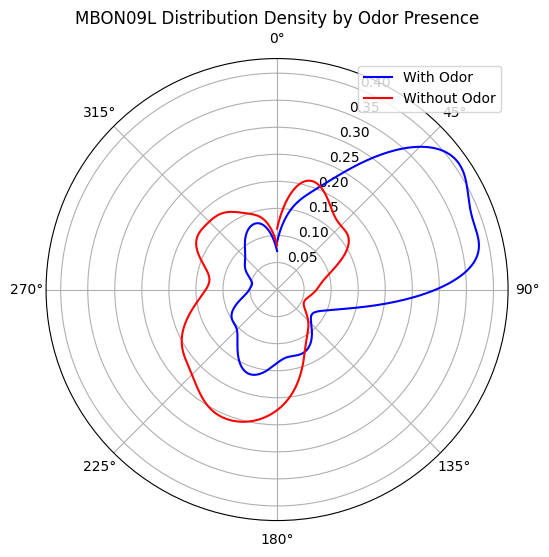

In [57]:
def circular_kde(data, headings, bandwidth=0.1):
    """
    Perform KDE on circular data (MBON09L values) with respect to the heading (in radians).
    
    Parameters:
    - data: The data values (e.g., MBON09L) for which we want to compute density.
    - headings: Circular variable (heading in radians) as the angular support.
    - bandwidth: Bandwidth for KDE.
    
    Returns:
    - kde_values: KDE estimated values.
    - theta_grid: Corresponding angular grid points (in radians).
    """
    theta_grid = np.linspace(0, 2 * np.pi, 500)  # 0 to 2*pi for the circular support
    kde = gaussian_kde(headings, weights=data, bw_method=bandwidth)
    kde_values = kde(theta_grid)
    
    return kde_values, theta_grid

with_odor = behav_df['odor'] > 5
without_odor = behav_df['odor'] <= 5

# Perform circular KDE for MBON09L distribution for both conditions
kde_with_odor, theta_grid = circular_kde(neural_df['MBON09L'][with_odor & (neural_df['MBON09L'] >= 0)], behav_df['heading'][with_odor & (neural_df['MBON09L'] >= 0)])
kde_without_odor, _ = circular_kde(neural_df['MBON09L'][without_odor & (neural_df['MBON09L'] >= 0)], behav_df['heading'][without_odor & (neural_df['MBON09L'] >= 0)])

# Plot the KDE results on the polar coordinate system
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': 'polar'})

# Plot KDE curve for with odor
ax.plot(theta_grid, kde_with_odor, label='With Odor', color='blue')

# Plot KDE curve for without odor
ax.plot(theta_grid, kde_without_odor, label='Without Odor', color='red')

# Add titles, legend, and labels
ax.set_title("MBON09L Distribution Density by Odor Presence")
ax.set_theta_zero_location('N')  # Set 0 degrees (north) at the top
ax.set_theta_direction(-1)       # Set the angular direction clockwise

# Add legend
ax.legend(loc="upper right")

plt.show()


In [58]:
np.where(neural_df['MBON09L'][with_odor]<0)

(array([1433, 1434, 1703, 1704, 1705, 1706], dtype=int64),)

### EPG processing 

In [5]:
epg_df = neural_df.filter(like='EPG')
epg_df

,EPG_0,EPG_1,EPG_2,EPG_3,EPG_4,EPG_5,EPG_6,EPG_7,EPG_8,EPG_9,...,EPG_20,EPG_21,EPG_22,EPG_23,EPG_24,EPG_25,EPG_26,EPG_27,EPG_28,EPG_29
0,2.723054,0.892353,1.214028,1.743374,2.166797,2.234061,3.058426,2.674723,2.845853,3.090423,...,1.778661,2.459945,2.474280,1.743127,1.903536,1.877679,1.714433,1.692436,1.355308,0.981021
1,2.864456,1.103269,1.143212,1.687360,2.074136,2.198340,2.757989,2.533699,2.644873,2.942089,...,1.762801,2.308727,2.410312,1.729007,2.047879,2.164652,2.136542,2.246190,1.914916,1.590011
2,3.738657,1.476766,1.308932,1.620242,1.944892,1.964879,2.320715,2.172650,2.277311,2.658761,...,1.508232,1.955571,2.123074,1.511344,2.087945,2.317293,2.457225,2.679639,2.448921,2.207648
3,4.636425,1.782339,1.477424,1.501613,1.705614,1.653203,1.928812,1.738895,1.871738,2.263781,...,1.190439,1.606212,1.756443,1.225380,2.056184,2.322880,2.607774,2.879525,2.760156,2.509236
4,5.248745,1.893037,1.570783,1.434932,1.479327,1.433266,1.633765,1.391593,1.505390,1.903914,...,0.993123,1.353303,1.454187,1.032984,1.954573,2.272118,2.633817,2.989960,2.861271,2.608892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,2.729314,2.416504,1.905878,0.930155,1.025140,0.267064,0.170871,0.304852,0.255301,0.627908,...,0.278155,0.177689,0.436523,0.415495,1.040792,1.464250,2.470433,2.659594,3.026334,3.505047
2053,2.701487,2.401290,1.726724,0.879139,0.960849,0.369732,0.223090,0.288241,0.201353,0.550387,...,0.228247,0.212573,0.398730,0.419965,0.991494,1.491411,2.483958,2.652767,2.948268,3.443189
2054,2.074075,2.155816,1.477726,0.893341,0.900961,0.448354,0.260100,0.230421,0.219046,0.573498,...,0.218835,0.232854,0.484072,0.461322,0.991760,1.543880,2.520692,2.705019,2.880502,3.289761
2055,1.723742,1.951129,1.303298,0.988706,0.984354,0.465009,0.250617,0.194844,0.260288,0.614825,...,0.259136,0.219845,0.604700,0.505460,1.009610,1.518933,2.422403,2.714442,2.869919,3.184348


<Axes: >

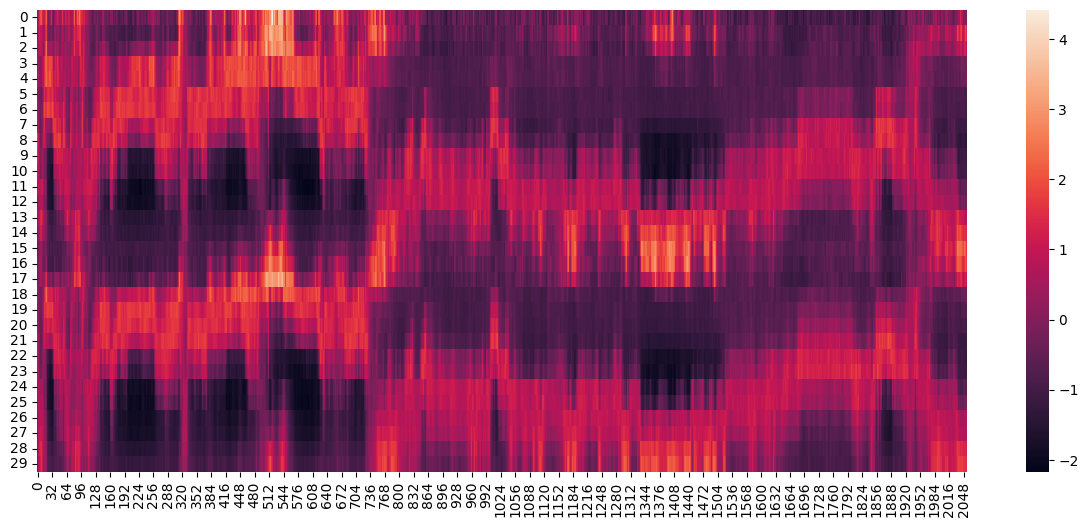

In [6]:
scaler = StandardScaler()
roi_mtx_ori =  epg_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [7]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva_epg(np.transpose(roi_mtx))

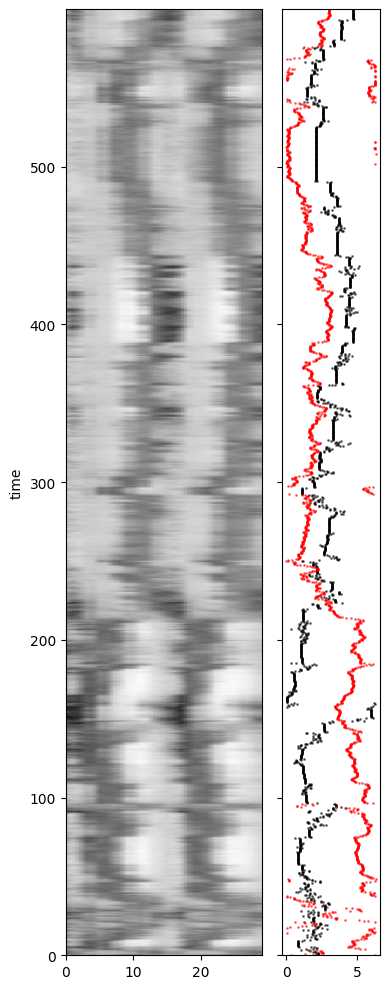

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()



In [21]:
# calculate offset
phase_dif_epg = np.angle(np.exp(1j*behav_df.heading[ind1:ind2])/np.exp(1j*(pva_phase[ind1:ind2]+np.pi))) 
phase_dif_epg

array([1.7138969 , 1.94166096, 1.7783599 , ..., 1.86761494, 1.86154615,
       1.88850513])

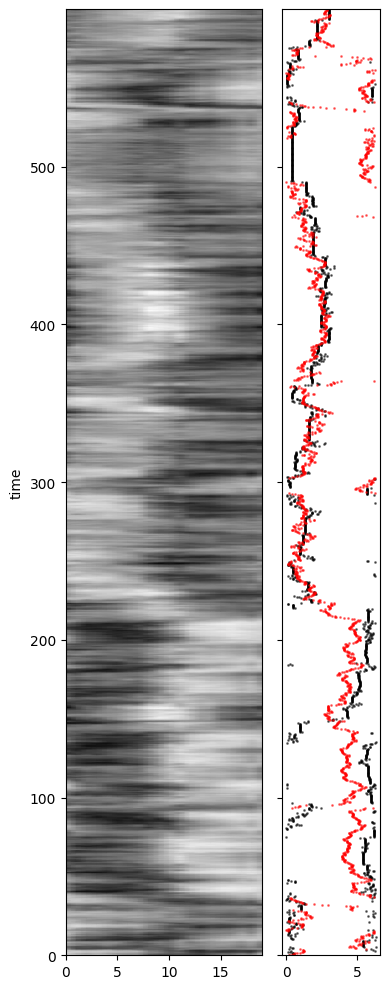

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
hd_zerooff = behav_df.heading-phase_dif_epg[0]
hd_zerooff[hd_zerooff<0] += 2*np.pi
ax2.scatter(hd_zerooff, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()
fig.savefig('epg.pdf', format='pdf', bbox_inches='tight')


Text(0, 0.5, 'heading')

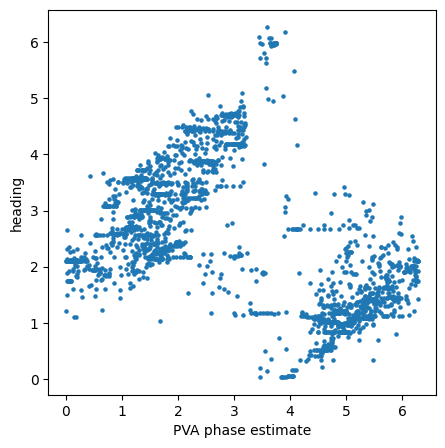

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pva_phase+np.pi, behav_df.heading, marker = 'o',s=5)
ax.set_xlabel('PVA phase estimate')
ax.set_ylabel('heading')

In [11]:

# Columns to smooth
cols_to_smooth = ['fwV','sideV','yawV']
sigma = 8
def smooth_columns(df, cols_to_smooth,sigma):
    # Create a new DataFrame with smoothed columns
    smoothed_df = pd.DataFrame()

    for col in df.columns:
        if col in cols_to_smooth:
            smoothed_data = gaussian_filter1d(df[col].values, sigma=sigma, mode='nearest')
            smoothed_df[col] = smoothed_data
        else:
            smoothed_df[col] = df[col]
    return smoothed_df

smoothed_df = smooth_columns(behav_df, cols_to_smooth,sigma)

In [12]:
smoothed_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos
0,0.000000,2.123724,-0.432361,-0.365113,1.909094,0.000000,0.000000,0.000000,0,1.909094,-0.000000,0.000000,0.000000
1,0.291806,2.438918,-0.509781,-0.409644,2.251022,2.601109,1.443248,5.483164,1,2.251022,-0.010547,0.194625,0.421125
2,0.583611,2.765627,-0.587406,-0.455153,2.222788,1.462957,0.027780,1.620589,1,2.222788,-0.011848,0.236184,0.472403
3,0.875417,3.096965,-0.661636,-0.501112,2.220486,1.073745,0.020996,1.172523,1,2.220486,-0.014612,0.207335,0.439565
4,1.167222,3.425018,-0.728759,-0.547022,2.221038,0.389426,0.013092,0.429046,1,2.221038,-0.012081,0.217654,0.451001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,598.784922,0.195282,0.376175,0.047876,4.709517,0.658852,0.022617,0.750958,1,10.992702,-0.189355,411.521830,960.690741
2053,599.076727,0.196734,0.412159,0.040330,4.710929,4.710858,0.050595,5.395737,1,10.994115,-0.183650,411.536975,960.418813
2054,599.368533,0.200856,0.433987,0.036021,4.717707,1.295829,0.019059,1.559361,1,11.000892,-0.178025,411.526640,960.512944
2055,599.660338,0.207034,0.444796,0.034267,4.711299,4.804269,0.103648,5.007310,1,10.994484,-0.184927,411.564481,960.639628


In [13]:
def calculate_translational_velocity_df(df):
    """
    Calculate translational velocities and directions for multiple time points provided in a DataFrame.

    Parameters:
        df (pandas.DataFrame): DataFrame containing columns 'fwV' for forward velocity (mm/s) 
                               and 'sideV' for side velocity (rad/s).
        radius (float): Radius of the ball in mm.
        heading_direction_rad (float): Instantaneous heading direction of the animal in radians (assumed constant for simplicity).

    Returns:
        pandas.DataFrame: DataFrame with additional columns 'translational_velocity_mm_s' and 'translational_direction_rad'.
    """
    # Convert side velocity from rad/s to mm/s
    #df['side_velocity_mm'] = df['sideV'] * radius

    # Calculate the magnitude of the translational velocity
    df['translational_velocity_mm_s'] = np.sqrt(df['sideV']**2 + df['fwV']**2)

    # Calculate the direction of the translational velocity
    df['translational_direction_rad'] = (df['heading'] + np.arctan2(df['sideV'], df['fwV'])) % (2*np.pi)


    return df

radius = 4.5 
result_df = calculate_translational_velocity_df(smoothed_df)
result_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos,translational_velocity_mm_s,translational_direction_rad
0,0.000000,2.123724,-0.432361,-0.365113,1.909094,0.000000,0.000000,0.000000,0,1.909094,-0.000000,0.000000,0.000000,2.167289,1.708252
1,0.291806,2.438918,-0.509781,-0.409644,2.251022,2.601109,1.443248,5.483164,1,2.251022,-0.010547,0.194625,0.421125,2.491626,2.044969
2,0.583611,2.765627,-0.587406,-0.455153,2.222788,1.462957,0.027780,1.620589,1,2.222788,-0.011848,0.236184,0.472403,2.827320,2.013503
3,0.875417,3.096965,-0.661636,-0.501112,2.220486,1.073745,0.020996,1.172523,1,2.220486,-0.014612,0.207335,0.439565,3.166852,2.010010
4,1.167222,3.425018,-0.728759,-0.547022,2.221038,0.389426,0.013092,0.429046,1,2.221038,-0.012081,0.217654,0.451001,3.501691,2.011389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,598.784922,0.195282,0.376175,0.047876,4.709517,0.658852,0.022617,0.750958,1,10.992702,-0.189355,411.521830,960.690741,0.423842,5.801482
2053,599.076727,0.196734,0.412159,0.040330,4.710929,4.710858,0.050595,5.395737,1,10.994115,-0.183650,411.536975,960.418813,0.456705,5.836382
2054,599.368533,0.200856,0.433987,0.036021,4.717707,1.295829,0.019059,1.559361,1,11.000892,-0.178025,411.526640,960.512944,0.478213,5.855043
2055,599.660338,0.207034,0.444796,0.034267,4.711299,4.804269,0.103648,5.007310,1,10.994484,-0.184927,411.564481,960.639628,0.490618,5.846461


In [14]:
hdeltab_df = neural_df.filter(like='hDeltaB')
hdeltab_df

,hDeltaB_0,hDeltaB_1,hDeltaB_2,hDeltaB_3,hDeltaB_4,hDeltaB_5,hDeltaB_6,hDeltaB_7,hDeltaB_8,hDeltaB_9,hDeltaB_10,hDeltaB_11,hDeltaB_12,hDeltaB_13,hDeltaB_14,hDeltaB_15,hDeltaB_16,hDeltaB_17,hDeltaB_18,hDeltaB_19
0,-0.193967,-0.000457,0.073373,0.019750,0.177525,0.426502,0.683414,0.780667,0.944247,1.071649,0.917875,0.786426,0.894922,1.093610,0.843931,0.730944,0.588569,0.487070,0.504135,0.010910
1,-0.116115,0.059882,0.099784,0.043648,0.168415,0.392602,0.599247,0.678869,0.904270,0.980953,0.896351,0.754305,0.864112,1.139721,0.946442,0.766402,0.670169,0.577942,0.567977,0.090014
2,-0.030915,0.105457,0.150837,0.090545,0.181895,0.361443,0.485518,0.530761,0.842716,0.871166,0.844065,0.692316,0.844093,1.152871,1.004232,0.780436,0.759679,0.640261,0.609428,0.160382
3,0.018073,0.113260,0.210224,0.118139,0.203891,0.350504,0.422369,0.423375,0.751085,0.746232,0.790395,0.628125,0.839876,1.127049,1.019851,0.769844,0.817656,0.648546,0.649909,0.196785
4,0.018680,0.136706,0.251679,0.129589,0.265536,0.385921,0.406132,0.398921,0.657362,0.672613,0.750189,0.607239,0.815054,1.112682,1.016412,0.791079,0.845272,0.668738,0.705568,0.211975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,0.725296,0.559247,0.465383,0.465341,0.371303,0.290641,0.151348,0.145858,0.216029,0.138736,0.044434,0.019219,0.129350,0.344191,0.601073,0.639127,0.735293,0.937902,0.830761,1.025948
2053,0.754518,0.641993,0.499176,0.443159,0.405628,0.296574,0.181517,0.110212,0.193165,0.177968,0.057779,0.030147,0.093549,0.342221,0.590682,0.618950,0.708239,0.926642,0.801019,1.074110
2054,0.745142,0.678675,0.520800,0.448398,0.436572,0.294794,0.163118,0.100149,0.178068,0.160501,0.078860,0.037575,0.117841,0.342180,0.610917,0.593001,0.674209,0.886596,0.796549,1.153398
2055,0.754913,0.655963,0.506834,0.480879,0.418295,0.333264,0.129951,0.092716,0.158295,0.138725,0.086364,0.048558,0.171463,0.321312,0.619844,0.596116,0.632169,0.834929,0.764140,1.193808


<Axes: >

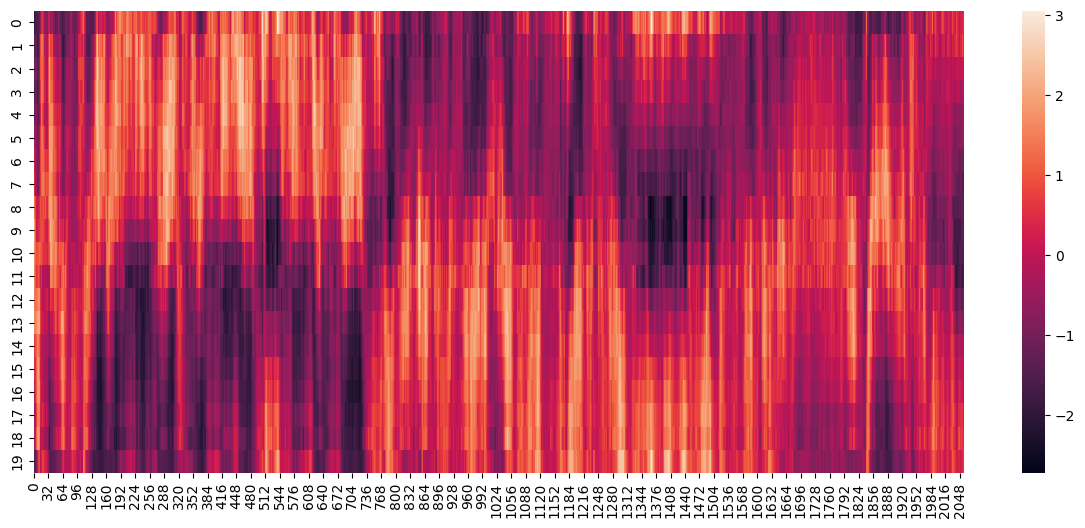

In [15]:
scaler = StandardScaler()
roi_mtx_ori =  hdeltab_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [16]:
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

,time,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error
0,0.000000,3.637634,0.162491,1.751337,0.068677,0.083554,0.116011
1,0.291806,3.637634,0.173620,1.613633,0.069444,0.078162,0.108998
2,0.583611,3.637634,0.140976,1.446100,0.073902,0.074983,0.105208
3,0.875417,3.968328,0.077666,1.301645,0.083940,0.077088,0.108779
4,1.167222,3.968328,0.058063,1.197554,0.098021,0.083132,0.117748
...,...,...,...,...,...,...,...
2052,598.784922,5.952491,-0.498071,1.023527,0.067553,0.047858,0.066187
2053,599.076727,0.000000,-0.482666,1.043530,0.063070,0.045518,0.062895
2054,599.368533,0.000000,-0.475032,1.054903,0.056112,0.040930,0.056543
2055,599.660338,0.000000,-0.487071,1.035013,0.049882,0.035700,0.049321


In [17]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva_hdeltab(np.transpose(roi_mtx))

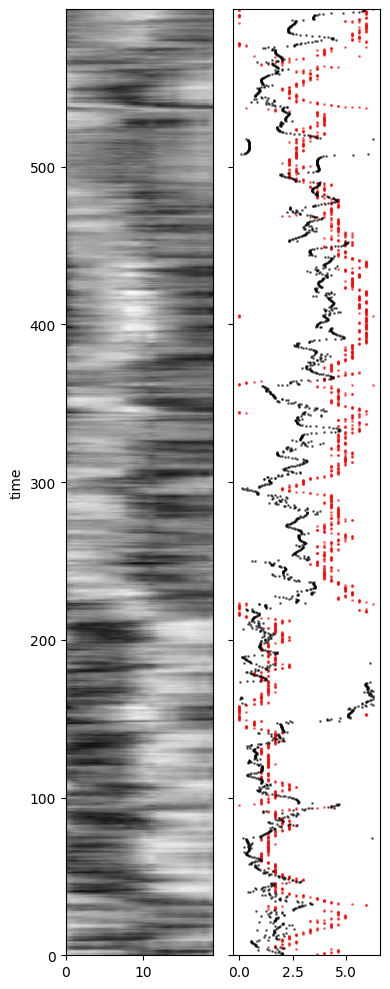

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.scatter(param_df.phase, behav_df.time, s=1,color='red',alpha=0.5,label='heading')
ax2.scatter(result_df.translational_direction_rad, behav_df.time, s=1,color='black',alpha=0.5,label='translational direction')
#ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
#ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')

#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()

In [28]:
# calculate offset
phase_dif_hdeltab = np.angle(np.exp(1j*param_df.phase[ind1:ind2])/np.exp(1j*result_df.translational_direction_rad)) 
phase_dif_hdeltab

array([1.92938122, 1.59266462, 1.62413038, ..., 0.42814227, 0.43672413,
       0.44168583])

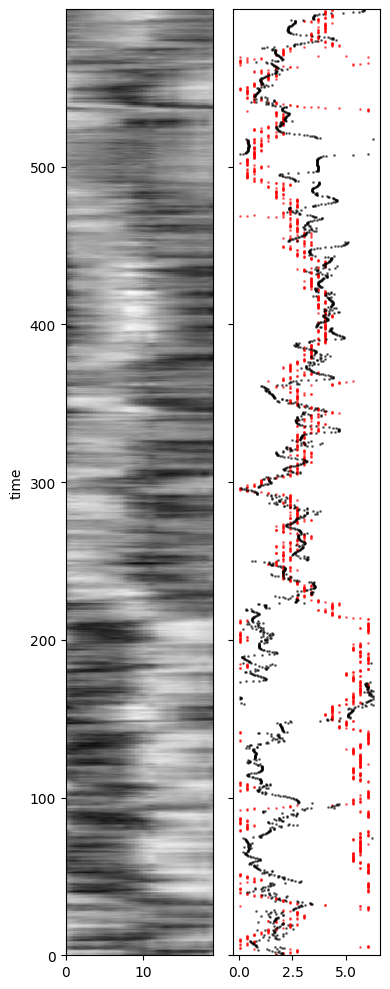

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
phase_zerooff = param_df.phase-phase_dif_hdeltab[0]
phase_zerooff[phase_zerooff<0] += 2*np.pi
ax2.scatter(phase_zerooff, behav_df.time, s=1,color='red',alpha=0.5,label='heading')
ax2.scatter(result_df.translational_direction_rad, behav_df.time, s=1,color='black',alpha=0.5,label='translational direction')
#ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
#ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')

#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()
fig.savefig('hdeltab.pdf', format='pdf', bbox_inches='tight')

Text(0, 0.5, 'phase')

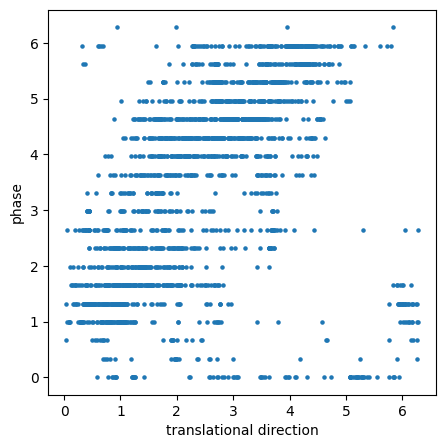

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_direction_rad, param_df.phase, marker = 'o',s=5)
#ax.scatter(behav_df.heading, pva_phase+np.pi, marker = 'o',color = 'red',s=5)
ax.set_xlabel('translational direction')
ax.set_ylabel('phase')

Text(0, 0.5, 'bump amplitude')

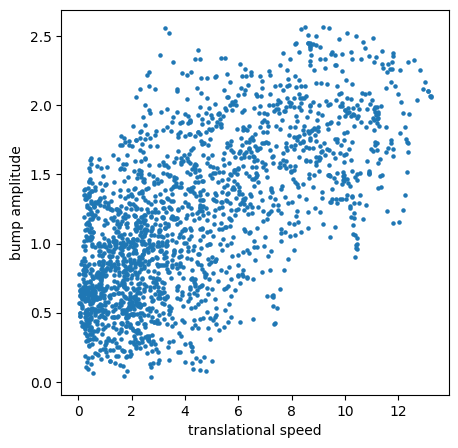

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_velocity_mm_s, param_df.amplitude, marker = 'o',s=5)
ax.set_xlabel('translational speed')
ax.set_ylabel('bump amplitude')